In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np

In [2]:
def read_data(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        pre_acc, post_acc, pruning_amount = [], [], []
        for line in lines[1:]:
            pruning, pre, _, post, _, _ = line.strip().split(',')
            pruning_amount.append(float(pruning))
            pre_acc.append(float(pre))
            post_acc.append(float(post))
        print(path, len(pruning_amount), len(pre_acc), len(post_acc))
        return pruning_amount, pre_acc, post_acc
    #pruning amount, pre_acc, pre_comp_time, post_acc, post_comp_time, model_size

In [3]:
def plot_data(pruning_amount, pre_acc, post_acc):
    plt.figure(figsize=(15, 5))
    plt.plot(pruning_amount, pre_acc, 'o-', label='Pre-fine-tuning accuracy', color='red')
    plt.plot(pruning_amount, post_acc, 'o-', label='Post-fine-tuning pruning accuracy', color='green')
    plt.xlabel('Pruning Amount')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [4]:
models_data = []

data_paths = [
    '../results/VGG11_results.csv',
    '../results/VGG13_results.csv',
    '../results/VGG16_results.csv',
    '../results/VGG19_results.csv',
    '../results/AlexNet_results.csv',
]

for data_path in data_paths:
    models_data.append(read_data(data_path))

../results/VGG11_results.csv 60 60 60
../results/VGG13_results.csv 60 60 60
../results/VGG16_results.csv 59 59 59
../results/VGG19_results.csv 60 60 60
../results/AlexNet_results.csv 60 60 60


In [5]:
X, y = [], []

for pruning, pre_acc, post_acc in models_data:
    initial_index = pruning.index(0)
    initial_acc = pre_acc[initial_index]
    
    for p, pre, post in zip(pruning, pre_acc, post_acc):
        X.append([p, pre, initial_acc])
        y.append(post)

In [6]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [7]:
indices = torch.randperm(X.size(0))
X = X[indices]
y = y[indices]

In [8]:
X[10], y[10]

(tensor([ 9.0000, 25.7500, 58.2000]), tensor([50.4000]))

In [9]:
# scaler_X = MinMaxScaler()
# X = torch.tensor(scaler_X.fit_transform(X), dtype=torch.float32)

# scaler_y = MinMaxScaler()
# y = torch.tensor(scaler_y.fit_transform(y), dtype=torch.float32)

In [10]:
class LearnData(nn.Module):
    def __init__(self):
        super(LearnData, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
    def forward(self, x):
        x = self.net(x)
        return torch.abs(x)

In [11]:
model = LearnData()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

model.to('mps')
X = X.to('mps')
y = y.to('mps')

In [12]:
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
print(f"Train Size: {len(X_train)}")
print(f"Test Size: {len(X_test)}")

Train Size: 239
Test Size: 60


In [13]:
num_epochs = 1000

In [14]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [0/1000], Loss: 1197.9392
Epoch [100/1000], Loss: 187.1589
Epoch [200/1000], Loss: 63.7353
Epoch [300/1000], Loss: 55.7920
Epoch [400/1000], Loss: 53.7823
Epoch [500/1000], Loss: 51.9498
Epoch [600/1000], Loss: 50.3197
Epoch [700/1000], Loss: 48.4160
Epoch [800/1000], Loss: 46.2092
Epoch [900/1000], Loss: 43.6527


In [15]:
len(X_test), len(y_test)

(60, 60)

In [16]:
# Getting 30 random samples
import random
random.seed(42)

indices = random.sample(range(len(X_test)), (len(X_test)-10))
X_test_samples = X_test[indices]
y_test_samples = y_test[indices]

In [17]:
model.eval()
max_error = 0.0
errors = []

preds, actuals = [], []

with torch.no_grad():
    pred = model(X_test_samples)
    # pred = scaler_y.inverse_transform(pred.cpu().numpy())
    # y_30_actual = scaler_y.inverse_transform(y_test_samples.cpu().numpy())
    # X_30_actal = scaler_X.inverse_transform(X_test_samples.cpu().numpy())
    
    pred = pred
    y_30_actual = y_test_samples
    X_30_actal = X_test_samples
    
    for i in range(len(pred)):
        error = abs(float(((pred[i] - y_30_actual[i])).item()))
        if error >= max_error:
            max_error = error
        print(f"Predicted: {pred[i].item():.2f}% \t\t Actual: {y_30_actual[i].item():.2f}%, \t\t\t Error: {error:.2f}%, \t\tFor Pruning Amount: {X_30_actal[i][0]:.1f}%")
        preds.append(pred[i].item())
        actuals.append(y_30_actual[i].item())
        errors.append(error)

Predicted: 39.14% 		 Actual: 40.90%, 			 Error: 1.76%, 		For Pruning Amount: 21.0%
Predicted: 39.57% 		 Actual: 37.83%, 			 Error: 1.74%, 		For Pruning Amount: 12.0%
Predicted: 22.22% 		 Actual: 11.90%, 			 Error: 10.32%, 		For Pruning Amount: 37.0%
Predicted: 7.84% 		 Actual: 17.47%, 			 Error: 9.63%, 		For Pruning Amount: 46.0%
Predicted: 61.39% 		 Actual: 60.15%, 			 Error: 1.24%, 		For Pruning Amount: 3.0%
Predicted: 11.78% 		 Actual: 28.11%, 			 Error: 16.33%, 		For Pruning Amount: 41.0%
Predicted: 35.76% 		 Actual: 33.85%, 			 Error: 1.91%, 		For Pruning Amount: 18.0%
Predicted: 13.37% 		 Actual: 2.00%, 			 Error: 11.37%, 		For Pruning Amount: 46.0%
Predicted: 10.17% 		 Actual: 12.50%, 			 Error: 2.33%, 		For Pruning Amount: 45.0%
Predicted: 26.15% 		 Actual: 15.50%, 			 Error: 10.65%, 		For Pruning Amount: 34.0%
Predicted: 29.36% 		 Actual: 26.84%, 			 Error: 2.52%, 		For Pruning Amount: 30.0%
Predicted: 3.78% 		 Actual: 2.77%, 			 Error: 1.01%, 		For Pruning Amount: 56.0%
Predi

In [18]:
torch.save(model.state_dict(), 'approximation.pth')

In [19]:
print("Max Error:", max_error)
print("Mean Error:", np.mean(errors))

Max Error: 16.329532623291016
Mean Error: 5.5258173489570614


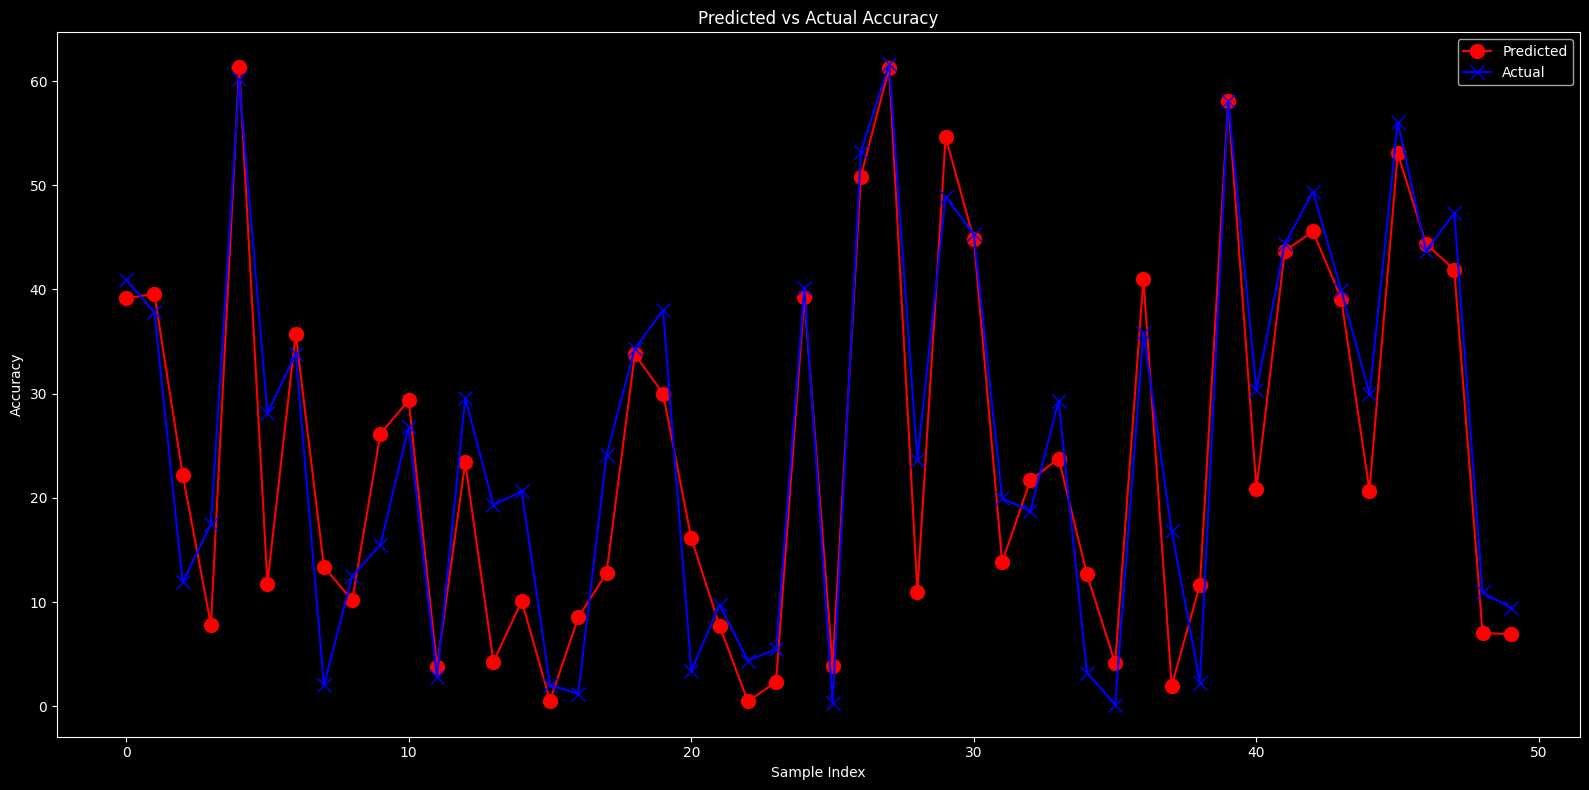

In [20]:
plt.figure(figsize=(16, 8))
plt.plot(preds, 'o-', label='Predicted', color='red', markersize=10)
plt.plot(actuals, 'x-', label='Actual', color='blue', markersize=10)
# plt.plot(errors, 's-', label='Error', color='blue', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Accuracy')
plt.title('Predicted vs Actual Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
def save_to_csv(preds, actuals, filename):
    with open(filename, 'w') as f:
        f.write('Predicted,Actual\n')
        for pred, actual in zip(preds, actuals):
            f.write(f'{pred},{actual}\n')
save_to_csv(preds, actuals, 'predictions.csv')

In [22]:
x = torch.tensor([14.0, 33.0, 55.0])

# x = torch.tensor(scaler_X.fit_transform(x), dtype=torch.float32)

x = x.unsqueeze(0)
x = x.to('mps')
model.eval()
with torch.no_grad():
    pred = model(x)
    # pred = scaler_y.inverse_transform(pred.cpu().numpy())
    print(f"Predicted: {pred.item():.2f}%")

Predicted: 54.27%
